# Event-Based Burstiness Analysis (HGMG vs LGMG)

This notebook focuses **exclusively on event-style burstiness features** for the
binary classification problem:

- **HGMG**: Human-generated, Mixtral-graded (Reuters-50/50 subset)
- **LGMG**: LLaMA-generated, Mixtral-graded (same prompt set), scored by Mixtral

## What do we mean by an "event"?

Throughout this notebook, an **event** refers to a token position in the
log-probability sequence where something "unusually surprising" happens.

Concretely, we consider the sequence of token probabilities under the scorer
(Mixtral), convert them to **surprisal** values (negative log-probabilities), and
then define *events* as token positions whose surprisal exceeds a chosen
threshold (e.g. the 80th percentile of surprisal within that document).

Intuitively:

- The surprisal time series tells us how "unexpected" each token is.
- **Events** are the spikes of high surprisal—tokens that the model finds hard
  to predict.
- We then treat the **positions of these events as a point process** and
  analyze its burstiness: how clustered vs evenly spaced the events are.

Instead of looking at the full spectrum of the log-probability signal, we
reduce attention to the *where and how* of surprising tokens, via features such
as:

- Inter-event distances and their variability
- Fano factors of event counts in fixed-size windows
- A classic burstiness index based on the mean and variance of inter-event times

We then:

1. Build an **event-burstiness feature dataframe** for HGMG vs LGMG.
2. Run **per-feature threshold search** for interpretability.
3. Train a **Random Forest classifier** using event-burstiness features only.


In [8]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from fingerprinting_llms.score import LogProbs

HUMAN_ROOT_LLAMA    = 'data/tokens/human_llama-graded/reuter5050/C50train_clean'
HUMAN_ROOT_MIXTRAL  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
LLM_ROOT_LLAMA      = 'data/tokens/llama70Bw4a16/reuter5050/C50train_clean'
LLM_ROOT_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'

RNG = np.random.default_rng(42)


## Data Loading Helpers

In [9]:
def find_all_npz(root_dir: str) -> list[str]:
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' not in npzfile:
                    continue
                probs = np.asarray(npzfile['token_probs'], dtype=np.float64)

        #logp = np.log(np.clip(probs, 1e-45, 1.0))
        series.append(probs)
    return series


## Event Definition and Burstiness Feature Design

We operate on per-token probabilities `p_t` scored by Mixtral and convert them
to surprisal values `s_t = -log(p_t)` (using natural log). For each document:

1. Compute surprisal sequence `s_t` from the stored probabilities.
2. Define a **surprisal threshold** based on a document-specific quantile
   (e.g. 80th percentile).
3. Mark an **event** wherever `s_t >= threshold`.
4. From the resulting binary event sequence, derive features such as:

   - Event rate (fraction of tokens that are events)
   - Inter-event distance statistics (mean, std, CV, burstiness index)
   - Fano factors of event counts in fixed-size windows

These features characterize how clustered or evenly spaced the high-surprisal
tokens are, which we hypothesize differs between human- and LLM-generated text.


In [28]:
def probs_to_surprisal(probs: np.ndarray, eps: float = 1e-45) -> np.ndarray:
    """Convert probabilities or log-probabilities to surprisal.

    If all values are <= 0, we interpret them as log-probabilities (log p)
    and use surprisal = -log p. Otherwise we treat them as raw probabilities.
    """
    probs = np.asarray(probs, dtype=np.float64)

    # Handle empty
    if probs.size == 0:
        return probs

    # Heuristic: if everything <= 0, treat as log-probs
    if np.all(probs <= 0):
        # probs is actually log p
        return -probs  # surprisal = -log p
    else:
        # probs is in probability space
        probs = np.clip(probs, eps, 1.0)
        return -np.log(probs)


def event_indicator_from_surprisal(s: np.ndarray,
                                   quantile: float = 0.8) -> np.ndarray:
    """Return a 1D binary event indicator array where surprisal exceeds a threshold.

    Tokens with surprisal >= document-specific quantile are marked as events.
    """
    s = np.asarray(s, dtype=np.float64)
    s = np.atleast_1d(s)  # ensure 1D, even if scalar

    if s.size == 0:
        return np.zeros(0, dtype=int)

    thr = np.quantile(s, quantile)
    events = (s >= thr).astype(int)
    events = np.atleast_1d(events)
    return events


def inter_event_distances(events: np.ndarray) -> np.ndarray:
    """Compute distances (in tokens) between successive events.

    If there are fewer than 2 events, return an empty array.
    """
    events = np.asarray(events, dtype=int)
    events = np.atleast_1d(events)  # <-- critical fix

    idx = np.nonzero(events)[0]
    if idx.size < 2:
        return np.array([], dtype=np.float64)
    d = np.diff(idx).astype(np.float64)
    return d


def fano_factor_event_counts(events: np.ndarray, window_size: int) -> float:
    """Compute the Fano factor of event counts in non-overlapping windows.

    Fano factor = variance(counts) / mean(counts). If mean(counts) == 0,
    returns 0.0.
    """
    events = np.asarray(events, dtype=int)
    events = np.atleast_1d(events)

    n = events.size
    if n == 0 or window_size < 1:
        return 0.0
    num_windows = n // window_size
    if num_windows < 2:
        return 0.0
    reshaped = events[:num_windows * window_size].reshape(num_windows, window_size)
    counts = reshaped.sum(axis=1).astype(np.float64)
    mean_c = counts.mean()
    if mean_c <= 0:
        return 0.0
    var_c = counts.var(ddof=1) if counts.size > 1 else 0.0
    return float(var_c / mean_c)


def burstiness_index(distances: np.ndarray) -> float:
    """Compute a classic burstiness index from inter-event distances.

    B = (sigma - mu) / (sigma + mu)

    - B -> -1 for perfectly regular distances (sigma << mu)
    - B -> 0  for Poisson-like (sigma ~ mu)
    - B -> 1  for highly bursty (sigma >> mu)
    """
    d = np.asarray(distances, dtype=np.float64)
    d = d[np.isfinite(d)]
    if d.size == 0:
        return 0.0
    mu = d.mean()
    sigma = d.std(ddof=1)
    if (sigma + mu) == 0:
        return 0.0
    return float((sigma - mu) / (sigma + mu))


def event_burstiness_features_from_probs(probs: np.ndarray,
                                         quantiles: list[float] = [0.8],
                                         fano_window_sizes=(32, 64, 128)) -> dict[str, float]:
    """Compute a set of event-burstiness features from token probabilities/logprobs."""
    feats: dict[str, float] = {}

    for quantile in quantiles:
        probs = np.asarray(probs, dtype=np.float64)

        # Handle empty or single-token documents as degenerate
        if probs.size < 2:
            base = {
                f'event_fraction_{quantile}': 0.0,
                f'inter_event_mean_{quantile}': 0.0,
                f'inter_event_std_{quantile}': 0.0,
                f'inter_event_cv_{quantile}': 0.0,
                f'inter_event_burstiness_{quantile}': 0.0,
            }
            base.update({f'fano_w{w}_{quantile}': 0.0 for w in fano_window_sizes})
            return base

        # Convert to surprisal (handling logprobs vs probs)
        s = probs_to_surprisal(probs)
        events = event_indicator_from_surprisal(s, quantile=quantile)

        # Basic event rate
        event_fraction = float(events.mean())
        feats[f'event_fraction_{quantile}'] = event_fraction

        # Inter-event distance stats
        d = inter_event_distances(events)
        if d.size == 0:
            feats[f'inter_event_mean_{quantile}'] = 0.0
            feats[f'inter_event_std_{quantile}'] = 0.0
            feats[f'inter_event_cv_{quantile}'] = 0.0
            feats[f'inter_event_burstiness_{quantile}'] = 0.0
        else:
            mu = float(d.mean())
            sigma = float(d.std(ddof=1))
            cv = float(sigma / mu) if mu > 0 else 0.0
            feats[f'inter_event_mean_{quantile}'] = mu
            feats[f'inter_event_std_{quantile}'] = sigma
            feats[f'inter_event_cv_{quantile}'] = cv
            feats[f'inter_event_burstiness_{quantile}'] = burstiness_index(d)

        # Fano factors at different window sizes
        for w in fano_window_sizes:
            feats[f'fano_w{w}_{quantile}'] = fano_factor_event_counts(events, window_size=w)

    return feats


## Build Event-Burstiness Feature DataFrame (HGMG vs LGMG)

We now build a dataframe of event-based burstiness features for:

- Human-generated, Mixtral-graded (HGMG) documents from `HUMAN_ROOT_MIXTRAL`
- LLaMA-generated, Mixtral-graded (LGMG) documents from `LLM_ROOT_MIXTRAL`


In [30]:
def build_event_feature_df(human_root: str,
                           llm_root: str,
                           quantiles: float = [0.8],
                           fano_window_sizes=(32, 64, 128)) -> pd.DataFrame:
    human_series = load_logp_series_from_root(human_root)
    llm_series   = load_logp_series_from_root(llm_root)

    rows = []
    for idx, probs in enumerate(human_series):
        feats = event_burstiness_features_from_probs(probs, quantiles=quantiles,
                                                     fano_window_sizes=fano_window_sizes)
        feats['label'] = 'human'
        feats['doc_id'] = f'human_{idx}'
        rows.append(feats)

    for idx, probs in enumerate(llm_series):
        feats = event_burstiness_features_from_probs(probs, quantiles=quantiles,
                                                     fano_window_sizes=fano_window_sizes)
        feats['label'] = 'llm'
        feats['doc_id'] = f'llm_{idx}'
        rows.append(feats)

    df = pd.DataFrame(rows)
    return df.reset_index(drop=True)

# Build the core dataframe for event-burstiness features (HGMG vs LGMG)
df_events_mixtral = build_event_feature_df(HUMAN_ROOT_MIXTRAL, LLM_ROOT_MIXTRAL,
                                           quantiles=[0.8, 0.9, 0.95, 0.98],
                                           fano_window_sizes=(32, 64, 128))
df_events_mixtral.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,event_fraction_0.8,inter_event_mean_0.8,inter_event_std_0.8,inter_event_cv_0.8,inter_event_burstiness_0.8,fano_w32_0.8,fano_w64_0.8,fano_w128_0.8,event_fraction_0.9,inter_event_mean_0.9,...,event_fraction_0.98,inter_event_mean_0.98,inter_event_std_0.98,inter_event_cv_0.98,inter_event_burstiness_0.98,fano_w32_0.98,fano_w64_0.98,fano_w128_0.98,label,doc_id
0,0.200903,4.977273,4.847033,0.973833,-0.013257,1.468627,1.870270,0.378378,0.101580,9.818182,...,0.020316,54.000000,49.155729,0.910291,-0.046961,0.809524,0.828571,0.142857,human,human_0
1,0.200737,4.935185,4.861201,0.985009,-0.007552,1.409241,2.125884,4.630363,0.101289,9.833333,...,0.020258,48.000000,52.866709,1.101390,0.048249,0.915152,1.025974,1.787879,human,human_1
2,0.202128,5.055556,4.633284,0.916474,-0.043583,0.600000,0.000000,0.000000,0.106383,9.777778,...,0.021277,88.000000,NaN,NaN,NaN,1.000000,0.000000,0.000000,human,human_2
3,0.201354,4.788136,4.109301,0.858226,-0.076296,0.589718,0.241597,0.222222,0.101523,8.932203,...,0.020305,47.090909,34.832326,0.739683,-0.149635,0.705882,0.937500,1.060606,human,human_3
4,0.200873,4.747253,4.703647,0.990815,-0.004614,1.280936,1.557971,0.011236,0.100437,8.800000,...,0.021834,41.111111,29.662453,0.721519,-0.161765,0.738462,1.366667,0.700000,human,human_4


## Train / Validation Split

In [32]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    train_df = df_in.iloc[train_idx].reset_index(drop=True)
    val_df   = df_in.iloc[val_idx].reset_index(drop=True)
    return train_df, val_df


## Per-Feature Threshold Search

We reuse the same threshold-search machinery as in the previous notebooks:
for each scalar feature, we search over thresholds and directions (`>=`/`<=`)
on the training set to maximize macro-F₁, then evaluate that 1D classifier on
both train and validation splits.


In [33]:
from dataclasses import dataclass
from typing import List, Tuple, Dict

@dataclass
class ThresholdResult:
    feature: str
    direction: str
    threshold: float
    degenerate: bool
    train_accuracy: float
    train_precision: float
    train_recall: float
    train_f1_macro: float
    train_auroc: float
    val_accuracy: float
    val_precision: float
    val_recall: float
    val_f1_macro: float
    val_auroc: float

def _eval_threshold(y_true: np.ndarray,
                    scores: np.ndarray,
                    threshold: float,
                    direction: str,
                    positive_label: int = 1) -> Tuple[np.ndarray, Dict[str,float]]:
    """Apply a single threshold to scores and compute metrics."""
    if direction == '>=':
        y_pred = (scores >= threshold).astype(int)
    else:
        y_pred = (scores <= threshold).astype(int)

    degenerate = (y_pred.min() == y_pred.max())
    metrics = {}
    metrics['degenerate'] = degenerate
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        metrics['auroc'] = roc_auc_score(y_true, scores)
    except Exception:
        metrics['auroc'] = np.nan
    return y_pred, metrics

def threshold_search_for_feature(train_df: pd.DataFrame,
                                 val_df: pd.DataFrame,
                                 feature: str,
                                 positive_label: str = 'human',
                                 n_grid: int = 200) -> ThresholdResult:
    """Find the best 1D threshold classifier for a given feature.

    The positive class is mapped from `positive_label`. We search over
    `>=` and `<=` directions and a grid of thresholds spanning the feature
    range in the training set.
    """
    # Encode labels as 0/1
    y_train = (train_df['label'] == positive_label).astype(int).values
    y_val   = (val_df['label'] == positive_label).astype(int).values

    x_train = train_df[feature].values.astype(float)
    x_val   = val_df[feature].values.astype(float)

    finite_mask = np.isfinite(x_train)
    x_train = x_train[finite_mask]
    y_train_nonan = y_train[finite_mask]
    if x_train.size == 0:
        return ThresholdResult(feature, '>=', np.nan, True,
                               np.nan, np.nan, np.nan, np.nan, np.nan,
                               np.nan, np.nan, np.nan, np.nan, np.nan)

    lo, hi = np.nanmin(x_train), np.nanmax(x_train)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = lo, lo + 1e-6

    grid = np.linspace(lo, hi, n_grid)
    best_res = None
    best_score = -1.0

    for direction in ('>=','<='):
        for t in grid:
            _, m_train = _eval_threshold(y_train_nonan, x_train, t, direction)
            if m_train['f1_macro'] > best_score:
                best_score = m_train['f1_macro']
                best_res = (t, direction, m_train)

    # Recompute metrics on full train and validation with best threshold
    best_t, best_dir, train_metrics = best_res
    _, train_metrics_full = _eval_threshold(y_train, train_df[feature].values.astype(float), best_t, best_dir)
    _, val_metrics = _eval_threshold(y_val, val_df[feature].values.astype(float), best_t, best_dir)

    return ThresholdResult(
        feature=feature,
        direction=best_dir,
        threshold=float(best_t),
        degenerate=train_metrics_full['degenerate'],
        train_accuracy=train_metrics_full['accuracy'],
        train_precision=train_metrics_full['precision_macro'],
        train_recall=train_metrics_full['recall_macro'],
        train_f1_macro=train_metrics_full['f1_macro'],
        train_auroc=train_metrics_full['auroc'],
        val_accuracy=val_metrics['accuracy'],
        val_precision=val_metrics['precision_macro'],
        val_recall=val_metrics['recall_macro'],
        val_f1_macro=val_metrics['f1_macro'],
        val_auroc=val_metrics['auroc'],
    )


## Event-Burstiness Deep Dive: Threshold Search

We now:

1. Split into train/validation sets.
2. Run threshold search for each event-burstiness feature.
3. Inspect which features are individually most discriminative.


In [34]:
# Split train/validation
train_events, val_events = stratified_train_val_split(df_events_mixtral, test_size=0.2, seed=42)

# Identify event-burstiness feature columns
event_features = [c for c in df_events_mixtral.columns if c not in ('label', 'doc_id')]

# Run threshold search per feature
event_thresh_results = []
for feat in event_features:
    res = threshold_search_for_feature(train_events, val_events, feature=feat,
                                       positive_label='human', n_grid=200)
    event_thresh_results.append(res.__dict__)

event_thresh_df = pd.DataFrame(event_thresh_results).sort_values('val_f1_macro', ascending=False)
event_thresh_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_macro,val_auroc
17,inter_event_mean_0.95,>=,18.701843,False,0.781206,0.736519,0.709295,0.719697,0.747894,0.777620,0.731149,0.711699,0.719668,0.747806
5,fano_w32_0.8,<=,1.465178,False,0.761702,0.710848,0.675441,0.686952,0.302058,0.767705,0.717998,0.701845,0.708582,0.263602
9,inter_event_mean_0.9,>=,9.673367,False,0.783333,0.738347,0.717974,0.726332,0.733015,0.767705,0.718029,0.700417,0.707643,0.725689
25,inter_event_mean_0.98,>=,44.110553,False,0.745745,0.689015,0.676028,0.681439,0.715828,0.737960,0.682060,0.679417,0.680687,0.742888
6,fano_w64_0.8,<=,1.973848,False,0.754255,0.703495,0.648296,0.661011,0.349165,0.764873,0.720021,0.665592,0.679740,0.334306
1,inter_event_mean_0.8,>=,4.907035,False,0.745745,0.688002,0.666697,0.674544,0.697860,0.747875,0.691447,0.670718,0.678477,0.687083
4,inter_event_burstiness_0.8,<=,0.027571,False,0.727660,0.663103,0.643892,0.650651,NaN,0.745042,0.687732,0.668718,0.675949,0.291816
3,inter_event_cv_0.8,<=,1.087450,False,0.746454,0.690381,0.639563,0.650964,NaN,0.757790,0.708420,0.657738,0.670748,0.291816
11,inter_event_cv_0.9,<=,1.130020,False,0.719858,0.653184,0.637313,0.643069,NaN,0.740793,0.681603,0.660010,0.667765,0.306019
2,inter_event_std_0.8,<=,5.419080,False,0.741135,0.683183,0.624327,0.634340,NaN,0.756374,0.708840,0.648175,0.661334,0.316437


## Random Forest on Event-Burstiness Features Only

Finally, we train a Random Forest classifier using only event-burstiness
features and evaluate performance on the validation set.


Mixtral-graded (HGMG vs LGMG) : Event-burstiness-only Random Forest
accuracy (val):        0.827
precision_macro (val): 0.802
recall_macro (val):    0.762
f1_macro (val):        0.777
AUROC (val):           0.856


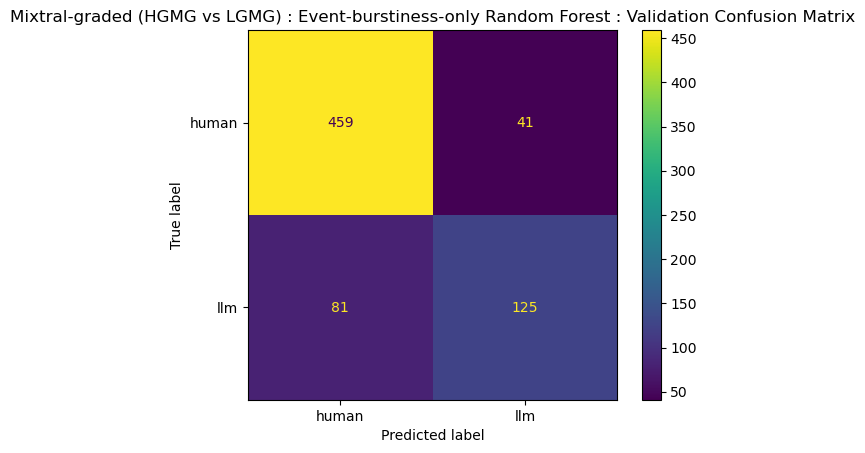

inter_event_mean_0.9          0.110144
inter_event_mean_0.95         0.095093
inter_event_mean_0.8          0.061998
fano_w32_0.8                  0.055445
inter_event_mean_0.98         0.055099
fano_w32_0.9                  0.045371
fano_w64_0.8                  0.043782
fano_w64_0.9                  0.032119
fano_w128_0.8                 0.028886
inter_event_cv_0.9            0.027185
inter_event_cv_0.8            0.026958
event_fraction_0.98           0.024917
inter_event_burstiness_0.8    0.024481
inter_event_burstiness_0.9    0.024386
fano_w32_0.95                 0.022867
inter_event_std_0.8           0.022663
event_fraction_0.9            0.020847
inter_event_std_0.9           0.020778
event_fraction_0.8            0.020634
fano_w128_0.9                 0.020519
dtype: float64

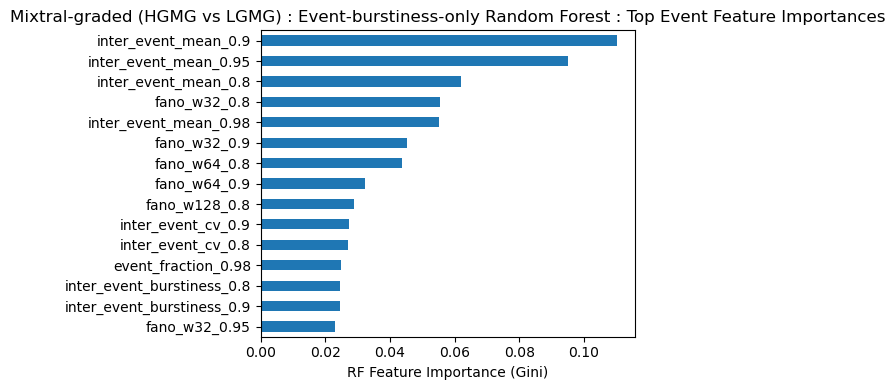

In [35]:
def model_eval_random_forest_subset(train_df: pd.DataFrame,
                                      val_df: pd.DataFrame,
                                      feature_cols: list[str],
                                      title: str = ""):
    # Prepare design matrices
    X_train = train_df[feature_cols].copy().fillna(train_df[feature_cols].mean())
    X_val   = val_df[feature_cols].copy().fillna(train_df[feature_cols].mean())

    le = LabelEncoder()
    le.fit(train_df['label'])
    y_train = le.transform(train_df['label'])
    y_val   = le.transform(val_df['label'])

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)

    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    rec  = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    f1m  = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    auroc = roc_auc_score(y_val, y_val_proba)

    print(f"{title}")
    print("="*len(title))
    print(f"accuracy (val):        {acc:.3f}")
    print(f"precision_macro (val): {prec:.3f}")
    print(f"recall_macro (val):    {rec:.3f}")
    print(f"f1_macro (val):        {f1m:.3f}")
    print(f"AUROC (val):           {auroc:.3f}")

    cm = confusion_matrix(y_val, y_val_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))
    disp.plot(values_format='d')
    plt.title(f'{title} : Validation Confusion Matrix')
    plt.show()

    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    display(importances.head(20))
    plt.figure(figsize=(6,4))
    importances.head(15).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.xlabel('RF Feature Importance (Gini)')
    plt.title(f'{title} : Top Event Feature Importances')
    plt.tight_layout()
    plt.show()

    return {
        'model': rf,
        'feature_cols': feature_cols,
        'label_encoder': le,
        'val_predictions': y_val_pred,
        'val_truth': y_val,
        'val_proba': y_val_proba,
        'val_feature_importances': importances,
    }

# Run RF on CV features only
event_rf_results = model_eval_random_forest_subset(
    train_events, val_events,
    feature_cols=event_features,
    title="Mixtral-graded (HGMG vs LGMG) : Event-burstiness-only Random Forest"
)


Mixtral-graded (HGMG vs LGMG) : Event-burstiness-only Random Forest
accuracy (val):        0.827
precision_macro (val): 0.802
recall_macro (val):    0.762
f1_macro (val):        0.777
AUROC (val):           0.856


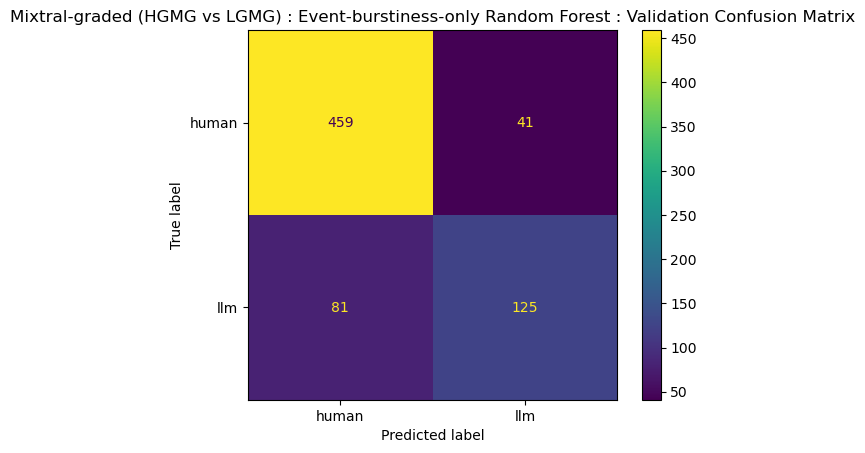

inter_event_mean_0.9          0.110144
inter_event_mean_0.95         0.095093
inter_event_mean_0.8          0.061998
fano_w32_0.8                  0.055445
inter_event_mean_0.98         0.055099
fano_w32_0.9                  0.045371
fano_w64_0.8                  0.043782
fano_w64_0.9                  0.032119
fano_w128_0.8                 0.028886
inter_event_cv_0.9            0.027185
inter_event_cv_0.8            0.026958
event_fraction_0.98           0.024917
inter_event_burstiness_0.8    0.024481
inter_event_burstiness_0.9    0.024386
fano_w32_0.95                 0.022867
inter_event_std_0.8           0.022663
event_fraction_0.9            0.020847
inter_event_std_0.9           0.020778
event_fraction_0.8            0.020634
fano_w128_0.9                 0.020519
dtype: float64

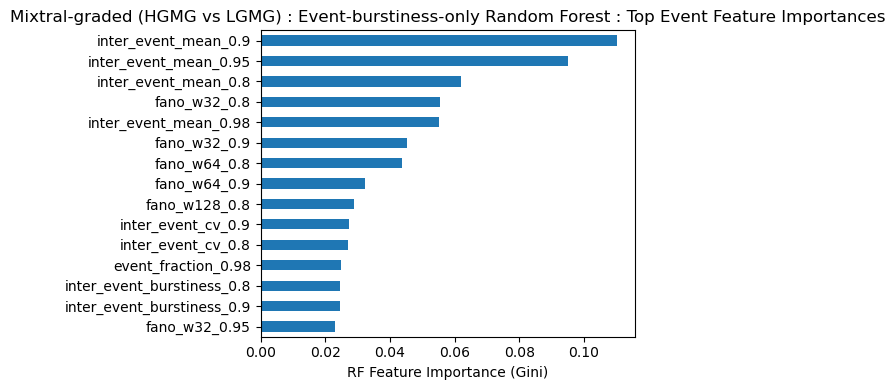

In [36]:
event_rf_results = model_eval_random_forest_subset(
    train_events, val_events, feature_cols=event_features,
    title='Mixtral-graded (HGMG vs LGMG) : Event-burstiness-only Random Forest'
)


## RESULTS
No improvement over our Burstiness-AllReuters-v2.ipynb notebook or Burstiness-StatsDeepDive-v1.ipynb notebook.